In [1]:
import numpy as np
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt

## K-armed Testbed

This is the basic environment for the bandit problem as discussed in Sutton & Barto.

In [143]:
from abc import ABC, abstractmethod
from typing import Optional

class Environment(ABC):
    """Abstract base class for k-armed bandit problem environments."""

    def __init__(self, k: int, baseline: float = 0.0):
        self._num_actions = k
        self._reward_means = self._generate_reward_means(baseline)
        self._opt_action = int(np.max(self._reward_means))

    @property
    def num_actions(self):
        """Getter for num_actions property."""
        return self._num_actions

    @property
    def opt_action(self):
        """Return the ground truth optimal action."""
        return self._opt_action


    def __call__(self, action: int):
        """Take an action and output a reward."""
        return self._action_to_reward(action=action)

    @abstractmethod
    def _action_to_reward(self, action: int):
        """Should house the actual mapping from action to reward."""
        pass

    def _generate_reward_means(self, baseline: float = 0.0):
        """Generate a set of k reward means from the unit normal dist.
        
        Args:
            baseline (float, optional): baseline reward to add to each
                randomly-generated reward value.

            Returns:
                float: (self.__k) draws from the unit normal dist.
        """
        return scipy.stats.norm(loc=0, scale=1).rvs(self.num_actions) + baseline


class KArmedTestBed(Environment):
    """General environment for the k-armed bandit problem,
    AKA the K-armed testbed.
    
    Should return rewards for actions taken, where rewards are
    stochastic.
    """
    def __init__(self, k: int, baseline: float = 0.0):
        super().__init__(k=k, baseline=baseline)
        self._reward_stds: np.ndarray = np.ones(k)


    def _action_to_reward(self, action: int):
        """Mapping from action to reward."""
        return self._reward_means[action] + self._reward_stds[action] * np.random.randn()

    
    def plot_reward_dists(self, ax: matplotlib.axes.Axes):
        """Plot the exact reward distributions of this environment."""
        for idx, rwm in enumerate(self._reward_means):
            y_p = scipy.stats.norm(loc=rwm, scale=1.).rvs(5_000)
            parts = ax.violinplot(
                y_p, 
                positions=[idx+1],
                showmeans=False,
                showextrema=False,
                points=10_000,
                )
            for pc in parts['bodies']:
                pc.set_facecolor('#000000')
                pc.set_alpha(.5)
            _width = 0.30
            ax.hlines(xmin=idx+1-_width, xmax=idx+1+_width, y=rwm, color='k', lw=.5)

        ax.plot([0,self.num_actions+1], [0, 0], color='k', linestyle='--', lw=1, alpha=0.5)
        ax.set(
            xlim=[0, self.num_actions+1],
            xticks=range(1, self.num_actions+1),
            xticklabels=[str(k) for k in range(1, self.num_actions + 1)],
            ylim=[-3.5,3.5],
            yticks=range(-3,4),
            yticklabels=[str(k) for k in range(-3, 4)],
            )
        ax.set_xlabel(xlabel='Action')
        ax.xaxis.set_label_coords(0.5, -0.15)
        ax.set_ylabel(ylabel='Reward\ndistribution', rotation=0) #, labelpad=35)
        ax.yaxis.set_label_coords(-0.15, 0.45)


# instantiate testbed object
env = KArmedTestBed(10)

# see what the underlying (latent) distributions look like
# fig, ax = plt.subplots(figsize=(6,4))
# env.plot_reward_dists(ax=ax)
# _ = ax.set_title(f'Randomly-generated testbed (k = {env.num_actions})')

env.num_actions
env(3)

1.1773979021440542

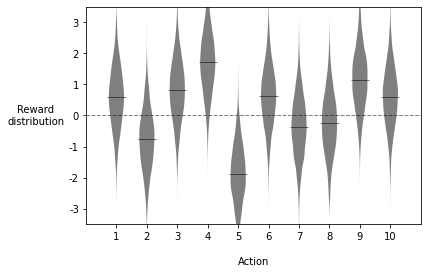

In [144]:
fig, ax = plt.subplots()
env.plot_reward_dists(ax)

In [145]:
class BanditMethod(ABC):
    """Base class for solving the k-armed bandit problem via
    action-value estimation.

    - Uses epsilon-greedy method to select actions.
    - Updates action-value estimate using sample-averages.
    """
    def __init__(self, k: int):
        self._num_actions = k
        self._q = np.zeros(self._num_actions)  # hold current action-value estimates

    @abstractmethod
    def select_action(self, env: Environment) -> int:
        """Look at the environment and somehow select an action.
        
            Arguments:
                env (Environment):
                    Current Environment in which the agent is acting.
            
            Returns:
                int:
                    Action the agent has selected.
        """
        pass

    @abstractmethod
    def update_action_values_(self,
        action_idx: int,
        reward: float,
        ):
        """After having selected an action, take the action; observe the response
            of the Environment; update action-values accordingly.

            Arguments:
                action_idx (int): 
                    Integer index of the action taken.
                reward (float):
                    Reward emitted by the Environment after taking the action.
        """
        pass

In [146]:
class EpsilonGreedy(BanditMethod):
    """Learning is done by considering actions taken and rewards seen.
        There is an inherent time/state component to this.

        Low epsilon: more greedy.
    """
    def __init__(self, k: int, epsilon: float = 1.0):
        super().__init__(k=k)
        self.epsilon: float = epsilon  # calls setter below
        self._n_selections: np.ndarray(dtype=int) = np.zeros(self._num_actions)  # counts of actions selections
        self.__total_reward: float = 0

    @staticmethod
    def _is_epsilon_valid(epsilon: float) -> None:
        """Raise ValueError if epsilon is invalid."""
        if not isinstance(epsilon, float):
            raise ValueError('epsilon must be a float!')
        if not (epsilon >= 0.0 and epsilon <= 1.0):
            raise ValueError('epsilon must be in the unit interval!')

    @property
    def epsilon(self):
        return self.__epsilon
    
    @epsilon.setter
    def epsilon(self, value: float):
        """Do input validation when setting epsilon."""
        self._is_epsilon_valid(value)
        self.__epsilon = value

    def select_action(self, env: Environment) -> int:
        """Select an action by epsilon-greedy selection."""
        if np.random.rand() > self.epsilon:  # do greedy selection
            arg_maxes = np.argwhere(self._q == np.amax(self._q).flatten()).flatten()
            action = np.random.choice(arg_maxes)
        else:  # exploratory
            arg_nmaxes = np.argwhere(self._q != np.amax(self._q).flatten()).flatten()
            # print(f"arg_nmaxes: {arg_nmaxes}")
            if arg_nmaxes.size > 0: 
                action = np.random.choice(arg_nmaxes)
            else:
                action = np.random.choice(range(self._num_actions))
        self._n_selections[action] += 1
        return action
        
    def update_action_values_(self,
        action_idx: int,
        reward: float,
        alpha: Optional[float] = None,
        ):
        """Update action-value estimates after taking an action and
        observing a reward. This will change for different bandit methods;
        the base implementation here is sample-averaging.

        Args:
            action_idx (int): 
            reward (float): 
            alpha (Optional[float], optional): _description_. Defaults to None.
        """
        if alpha:
            self._q[action_idx] += (reward - self._q[action_idx]) * alpha
        else:
            self._q[action_idx] += (reward - self._q[action_idx]) / self._n_selections[action_idx]
        return

In [152]:
def loop_step(env: Environment, bandit: BanditMethod):

    # select action
    action = bandit.select_action(env)
    # print(f"Selected action {action:d}")

    # take action in environment
    reward = env(action)
    # print(f"\tObtained reward {reward:.2f}")

    bandit.update_action_values_(action, reward)

    return action, reward

def plot_results(bandit: BanditMethod, env: Environment, ax):
    ax.bar(range(1, bandit._num_actions+1), bandit._q, color='black', alpha=0.5)
    ax.set(
        title=f'Estimated action-vaues (epsilon = {bandit.epsilon})',
        ylabel=r'$q\left(a\right)$',
        xlabel=r'$a$',
        xticks=range(1, bandit._num_actions+1),
        );
    _width = 0.50
    for idx, rwm in enumerate(env._reward_means):
        ax.hlines(xmin=idx+1-_width, xmax=idx+1+_width, y=rwm, color='r', lw=2)

def plot_avg_reward(ts_rewards, ax):
    ax.plot(ts_rewards.cumsum() / np.arange(start=1, stop=len(ts_best)+1, step=1))
    ax.set(xlabel='Steps', ylabel='Average reward', ylim=[0,2.0])

def plot_best_choice(ts_best, ax):
    ax.plot(ts_best.cumsum() / np.arange(start=1, stop=len(ts_best)+1, step=1))

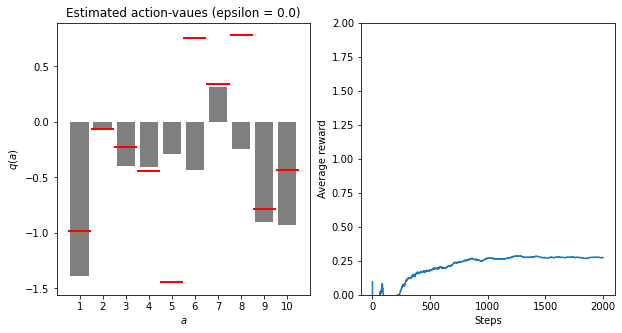

In [154]:
env = KArmedTestBed(k=10)
bandit = EpsilonGreedy(k=10, epsilon=0.)

best_action = np.argmax(env._reward_means)
n_steps = 2_000
n_best = 0
ts_best = np.zeros(n_steps)
ts_rewards = np.zeros(n_steps)

for n_iter in range(n_steps):
    action, reward = loop_step(env, bandit)
    ts_rewards[n_iter] = reward
    if action == best_action:
        ts_best[n_iter] = 1

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
plot_results(bandit, env, ax[0])
plot_avg_reward(ts_rewards, ax[1])

Any individual run of this algorithm will give different performance, since it's stochastic in nature. To get more comprehensive results, we could try averaging over a large number of runs.

In [201]:
epsilons = [0.0, 0.01, 0.1]

n_eps = len(epsilons)
n_runs = 2_000
n_steps = 1000
best_action = np.argmax(env._reward_means)
ts_rewards = np.zeros((n_eps, n_runs, n_steps))

for idx_eps, epsilon in enumerate(epsilons):
    print(f"Epsilon: {epsilon:.2f}")
    for n_run in range(n_runs):
        env = KArmedTestBed(k=10)
        bandit = EpsilonGreedy(k=10, epsilon=epsilon)
        for n_iter in range(n_steps):
            action, reward = loop_step(env, bandit)
            ts_rewards[idx_eps, n_run, n_iter] = reward

Epsilon: 0.00
Epsilon: 0.01
Epsilon: 0.10


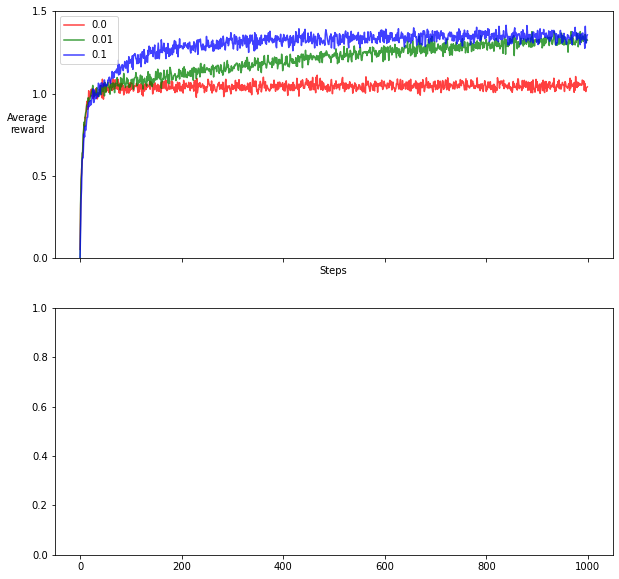

In [202]:
fig, ax = plt.subplots(nrows=2, figsize=(10,10), sharex=True)

avg_rewards = ts_rewards.mean(axis=1)

for idx, eps, col in zip(range(len(epsilons)), epsilons, ['red','green','blue']):
    ax[0].plot(avg_rewards[idx], alpha=0.75, color=col, label=eps)
ax[0].set(xlabel='Steps')
ax[0].set_ylabel(ylabel='Average\nreward', rotation=0)
ax[0].set_ylim([0, 1.5])
ax[0].set_yticks([0, 0.5, 1.0, 1.5])
ax[0].legend()


# ax[1].set(xlabel='Steps')
plt.show()